In [1]:
!pip install tiktoken verovio ultralytics

In [2]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True)
model = AutoModel.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True, low_cpu_mem_usage=True, device_map='cpu', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
model = model.eval().cuda()

In [16]:
# input your test image
image_file = '/kaggle/working/license_plate_crop.jpg'

In [17]:
res = model.chat(tokenizer, image_file, ocr_type='ocr')
print(res)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


R XI 3 F ZM



0: 416x640 1 car, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 License_Plate, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


R XI 3 F ZM


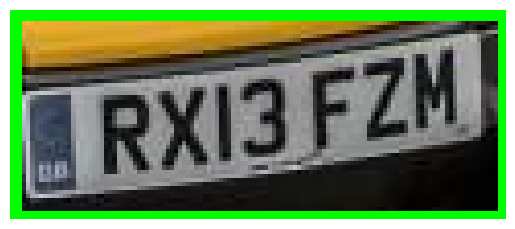

In [19]:

import numpy as np
from PIL import Image
from ultralytics import YOLO
import cv2
import pandas as pd
from PIL import Image

import uuid
import os
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt



tokenizer = AutoTokenizer.from_pretrained("ucaslcl/GOT-OCR2_0", trust_remote_code=True)
model = AutoModel.from_pretrained(
    "ucaslcl/GOT-OCR2_0",
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    device_map="cpu",
    use_safetensors=True,
    pad_token_id=tokenizer.eos_token_id,
)
model = model.eval().cuda()

LICENSE_MODEL_DETECTION_DIR = "/kaggle/input/test-ocr/weights/best.pt"
COCO_MODEL_DIR = "/kaggle/input/test-ocr/yolo11n.pt"

vehicles = [2]

# NOTE: run model!
coco_model = YOLO(COCO_MODEL_DIR)
license_plate_detector = YOLO(LICENSE_MODEL_DETECTION_DIR)

threshold = 0.15


def read_license_plate(license_plate_crop, img):
    scores = 0
    detections = reader.readtext(license_plate_crop)

    width = img.shape[1]
    height = img.shape[0]
    
    if detections == [] :
        return None, None

    rectangle_size = license_plate_crop.shape[0]*license_plate_crop.shape[1]

    plate = [] 

    for result in detections:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > 0.17:
            bbox, text, score = result
            text = result[1]
            text = text.upper()
            scores += score
            plate.append(text)
    
    if len(plate) != 0 : 
        return " ".join(plate), scores/len(plate)
    else :
        return " ".join(plate), 0


# NOTE: detect id vehicles
def model_prediction(img):
    license_numbers = 0
    results = {}
    licenses_texts = []
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    object_detections = coco_model(img)[0]
    
    license_detections = license_plate_detector(img)[0]

    if len(object_detections.boxes.cls.tolist()) != 0 :

        # NOTE: set variable model detect
        for detection in object_detections.boxes.data.tolist() :
            xcar1, ycar1, xcar2, ycar2, car_score, class_id = detection

            if int(class_id) in vehicles :
                cv2.rectangle(img, (int(xcar1), int(ycar1)), (int(xcar2), int(ycar2)), (0, 0, 255), 3)
    else :
            xcar1, ycar1, xcar2, ycar2 = 0, 0, 0, 0
            car_score = 0



    if len(license_detections.boxes.cls.tolist()) != 0 :
        license_plate_crops_total = []

        for license_plate in license_detections.boxes.data.tolist() :
            x1, y1, x2, y2, score, class_id = license_plate

            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)

            license_plate_crop = img[int(y1):int(y2), int(x1): int(x2), :]

            plt.imshow(cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            
            # Convert and save the cropped license plate image
            license_plate_crop_rgb = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2RGB)
            
            # Save the image to a specific path
            output_path = "license_plate_crop.jpg"  # Update the path as needed
            cv2.imwrite(output_path, cv2.cvtColor(license_plate_crop_rgb, cv2.COLOR_RGB2BGR))

            
            res = model.chat(tokenizer, '/kaggle/working/license_plate_crop.jpg', ocr_type='ocr')
            print(res)
    
    else : 
        img_wth_box = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return [img_wth_box]

img = cv2.imread('/kaggle/input/test-ocr/Car.jpeg')
image = np.array(Image.open('/kaggle/input/test-ocr/Car.jpeg')) 
model_prediction(image)
